# Bab 8: Reduksi Dimensi

Reduksi dimensi adalah teknik penting dalam Machine Learning yang bertujuan untuk mengurangi jumlah fitur (dimensi) dalam sebuah dataset sambil mempertahankan informasi yang paling relevan. Bab ini akan membahas mengapa reduksi dimensi itu penting, berbagai pendekatan, dan beberapa algoritma populer seperti PCA, Kernel PCA, dan LLE.

## 8.1 The Curse of Dimensionality

Ketika kita bekerja dengan dataset yang memiliki ribuan atau bahkan jutaan fitur untuk setiap instance pelatihan, kita menghadapi masalah yang dikenal sebagai **"kutukan dimensi" (curse of dimensionality)**.

Masalah ini menyebabkan beberapa kesulitan:
* **Pelatihan menjadi sangat lambat**: Semakin banyak fitur, semakin besar ruang pencarian dan semakin lama waktu yang dibutuhkan algoritma untuk belajar.
* **Sulit menemukan solusi yang baik**: Di ruang berdimensi tinggi, instance pelatihan cenderung sangat jarang (sparse), membuat setiap instance baru cenderung jauh dari instance pelatihan yang ada. Ini membuat prediksi kurang dapat diandalkan karena didasarkan pada ekstrapolasi yang jauh lebih besar.
* **Risiko overfitting**: Semakin banyak dimensi yang dimiliki dataset pelatihan, semakin besar risiko overfitting. Algoritma cenderung menemukan pola dalam kebisingan (noise) jika jumlah fitur terlalu tinggi relatif terhadap jumlah data pelatihan.
* **Kebutuhan data yang eksponensial**: Untuk mencapai kepadatan instance pelatihan tertentu, jumlah instance pelatihan yang dibutuhkan tumbuh secara eksponensial dengan jumlah dimensi.

**Contoh ilustrasi "kutukan dimensi"**:
Jika Anda mengambil titik acak dalam kotak satuan (1x1), hanya sekitar 0,4% kemungkinan titik tersebut berjarak kurang dari 0,001 dari batas. Namun, dalam hypercube 10.000 dimensi, probabilitas ini lebih besar dari 99,999999%. Ini menunjukkan bahwa sebagian besar titik di hypercube berdimensi tinggi sangat dekat dengan batas.

Secara teoritis, salah satu solusi untuk kutukan dimensi adalah dengan meningkatkan ukuran dataset pelatihan untuk mencapai kepadatan instance pelatihan yang memadai. Namun, dalam praktiknya, jumlah instance pelatihan yang dibutuhkan untuk mencapai kepadatan tertentu tumbuh secara eksponensial dengan jumlah dimensi, sehingga membuat hal ini tidak realistis.

Meskipun reduksi dimensi dapat mempercepat pelatihan, ia juga menyebabkan hilangnya beberapa informasi (mirip dengan kompresi gambar JPEG yang mengurangi kualitas). Oleh karena itu, penting untuk mencoba melatih sistem dengan data asli terlebih dahulu sebelum mempertimbangkan reduksi dimensi. Namun, dalam beberapa kasus, mengurangi dimensi data pelatihan dapat menyaring noise dan detail yang tidak perlu, sehingga menghasilkan kinerja yang lebih tinggi.

Reduksi dimensi juga sangat berguna untuk **visualisasi data (DataViz)**, memungkinkan kita untuk memplot tampilan ringkas dari dataset berdimensi tinggi dalam 2D atau 3D, membantu kita mendeteksi pola seperti klaster secara visual. DataViz juga penting untuk mengomunikasikan kesimpulan kepada orang-orang yang bukan ilmuwan data.

## 8.2 Main Approaches for Dimensionality Reduction

Sebelum menyelami algoritma reduksi dimensi tertentu, mari kita lihat dua pendekatan utama untuk mengurangi dimensi:
**proyeksi (projection)** dan **Manifold Learning**.

### 8.2.1 Projection

Pada sebagian besar masalah dunia nyata, instance pelatihan tidak tersebar secara seragam di semua dimensi. Banyak fitur yang hampir konstan, sementara yang lain sangat berkorelasi. Akibatnya, semua instance pelatihan terletak di dalam (atau dekat dengan) subruang berdimensi jauh lebih rendah dari ruang berdimensi tinggi.

**Proyeksi** melibatkan identifikasi subruang berdimensi rendah dan kemudian memproyeksikan data ke subruang tersebut.

**Contoh**:
Bayangkan dataset 3D yang semua titiknya terletak dekat dengan sebuah bidang (subruang 2D). Dengan memproyeksikan setiap instance pelatihan secara tegak lurus ke bidang ini, kita mendapatkan dataset 2D baru, sehingga mengurangi dimensi dari 3D menjadi 2D.

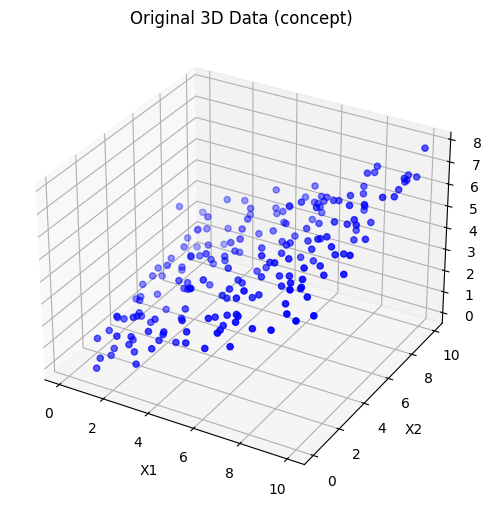

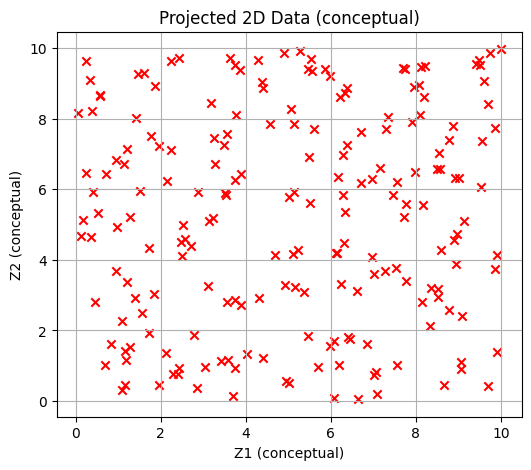

In [1]:
# Contoh konseptual Proyeksi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some 3D data close to a 2D plane
np.random.seed(42)
m = 200
X_3D = np.random.rand(m, 3) * 10
X_3D[:, 2] = X_3D[:, 0] * 0.5 + X_3D[:, 1] * 0.2 + np.random.randn(m) * 0.5

# Visualize the 3D data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c='b', marker='o')
ax.set_title("Original 3D Data (concept)")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()

# Conceptual Projection (e.g., dropping X3 dimension)
X_2D_projected = X_3D[:, :2]

# Visualize the 2D projected data
plt.figure(figsize=(6, 5))
plt.scatter(X_2D_projected[:, 0], X_2D_projected[:, 1], c='r', marker='x')
plt.title("Projected 2D Data (conceptual)")
plt.xlabel("Z1 (conceptual)")
plt.ylabel("Z2 (conceptual)")
plt.grid(True)
plt.show()

Namun, proyeksi tidak selalu merupakan pendekatan terbaik. Dalam banyak kasus, subruang dapat berbelok dan melengkung, seperti pada dataset Swiss roll yang terkenal. Cukup memproyeksikan ke bidang (misalnya, dengan menghilangkan $x_3$) akan menghimpit lapisan-lapisan yang berbeda dari Swiss roll, sementara yang sebenarnya diinginkan adalah "membuka" Swiss roll untuk mendapatkan dataset 2D.

### 8.2.2 Manifold Learning

**Manifold Learning** adalah pendekatan di mana algoritma reduksi dimensi bekerja dengan memodelkan manifold tempat instance pelatihan berada. Manifold $d$-dimensi adalah bagian dari ruang $n$-dimensi (di mana $d < n$) yang secara lokal menyerupai hyperplane $d$-dimensi.

**Asumsi manifold** (atau hipotesis manifold) menyatakan bahwa sebagian besar dataset berdimensi tinggi di dunia nyata terletak dekat dengan manifold berdimensi jauh lebih rendah.

**Contoh**:
Dataset MNIST (gambar digit tulisan tangan) adalah contoh yang baik. Semua gambar digit tulisan tangan memiliki kesamaan (garis terhubung, batas putih, dll.). Ini membatasi "derajat kebebasan" dalam menciptakan gambar digit, sehingga data cenderung "terjepit" ke dalam manifold berdimensi lebih rendah.

Seringkali, asumsi manifold juga disertai dengan asumsi implisit lain: bahwa tugas yang sedang dikerjakan (misalnya, klasifikasi atau regresi) akan lebih sederhana jika diekspresikan dalam ruang berdimensi rendah dari manifold. Namun, asumsi ini tidak selalu berlaku.

Secara singkat, mengurangi dimensi dataset pelatihan sebelum melatih model biasanya akan mempercepat pelatihan, tetapi mungkin tidak selalu mengarah pada solusi yang lebih baik atau lebih sederhana; semuanya tergantung pada dataset.

## 8.3 PCA (Principal Component Analysis)

**Principal Component Analysis (PCA)** adalah algoritma reduksi dimensi yang paling populer. Pertama, ia mengidentifikasi hyperplane yang paling dekat dengan data, dan kemudian memproyeksikan data ke hyperplane tersebut.

### 8.3.1 Preserving the Variance

Sebelum memproyeksikan dataset pelatihan ke hyperplane berdimensi lebih rendah, kita perlu memilih hyperplane yang tepat. PCA memilih sumbu (atau kombinasi sumbu) yang mempertahankan jumlah variansi maksimum, karena ini kemungkinan besar akan kehilangan lebih sedikit informasi. Atau, ini adalah sumbu yang meminimalkan jarak kuadrat rata-rata antara dataset asli dan proyeksinya pada sumbu tersebut.

### 8.3.2 Principal Components

PCA mengidentifikasi sumbu yang menjelaskan sebagian besar variansi dalam dataset pelatihan. Sumbu ke-$i$ disebut **komponen utama (PC)** ke-$i$ dari data.

Untuk menemukan komponen utama dataset pelatihan, kita dapat menggunakan teknik faktorisasi matriks standar yang disebut **Singular Value Decomposition (SVD)**. SVD dapat menguraikan matriks dataset pelatihan $X$ menjadi perkalian tiga matriks $U \Sigma V^\intercal$, di mana $V$ berisi vektor-vektor satuan yang mendefinisikan semua komponen utama.

$V = \begin{pmatrix} | & | & & | \\ \mathbf{c}_1 & \mathbf{c}_2 & \cdots & \mathbf{c}_n \\ | & | & & | \end{pmatrix}$

PCA mengasumsikan bahwa dataset terpusat di sekitar titik asal (mean 0). Kelas-kelas PCA di Scikit-Learn secara otomatis melakukan pemusatan data.

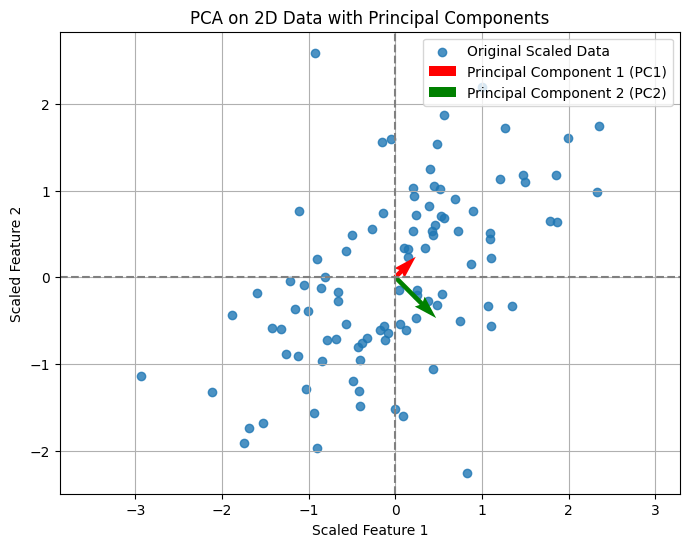

Explained Variance Ratio: [0.77130141 0.22869859]
Principal Components (vectors): 
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


In [2]:
# Contoh konseptual PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Generate some correlated 2D data
np.random.seed(42)
X = np.random.randn(100, 2)
X[:, 1] = X[:, 0] * 0.5 + np.random.randn(100) * 0.8

# Scale the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Visualize the data and principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.8, label='Original Scaled Data')
plt.quiver(0, 0, pca.components_[0, 0], pca.components_[0, 1],
           angles='xy', scale_units='xy', scale=3, color='r',
           label='Principal Component 1 (PC1)')
plt.quiver(0, 0, pca.components_[1, 0], pca.components_[1, 1],
           angles='xy', scale_units='xy', scale=1.5, color='g',
           label='Principal Component 2 (PC2)')
plt.axvline(0, linestyle='--', color='gray')
plt.axhline(0, linestyle='--', color='gray')
plt.title("PCA on 2D Data with Principal Components")
plt.xlabel("Scaled Feature 1")
plt.ylabel("Scaled Feature 2")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Principal Components (vectors): \n{pca.components_}")

### 8.3.3 Projecting Down to d Dimensions

Setelah mengidentifikasi semua komponen utama, Anda dapat mengurangi dimensi dataset menjadi $d$ dimensi dengan memproyeksikannya ke hyperplane yang ditentukan oleh $d$ komponen utama pertama. Pemilihan hyperplane ini memastikan bahwa proyeksi akan mempertahankan variansi sebanyak mungkin.

Untuk memproyeksikan dataset pelatihan ke hyperplane dan mendapatkan dataset tereduksi $X_{d-proj}$ dengan dimensi $d$, hitung perkalian matriks dari matriks dataset pelatihan $X$ dengan matriks $W_d$, yang didefinisikan sebagai matriks yang berisi $d$ kolom pertama dari $V$.

$X_{d-proj} = X W_d$

### 8.3.4 Using Scikit-Learn

Kelas `PCA` di Scikit-Learn menggunakan dekomposisi SVD untuk mengimplementasikan PCA. Anda dapat menentukan jumlah komponen yang ingin dipertahankan (`n_components`).

In [3]:
from sklearn.decomposition import PCA
import numpy as np

# Sample data (e.g., from X_scaled above)
X_example = np.array([[ 1.0, 0.5],
                      [-0.5, 1.2],
                      [ 0.8, 0.3],
                      [-1.0, -0.7]])

# Perform PCA to reduce to 1 dimension
pca_1d = PCA(n_components=1)
X_reduced_1d = pca_1d.fit_transform(X_example)
print(f"Original shape: {X_example.shape}")
print(f"Reduced shape (1D): {X_reduced_1d.shape}")
print(f"Reduced data (1D): \n{X_reduced_1d}")

Original shape: (4, 2)
Reduced shape (1D): (4, 1)
Reduced data (1D): 
[[ 0.90005747]
 [-0.10130926]
 [ 0.6299253 ]
 [-1.42867351]]


### 8.3.5 Explained Variance Ratio

**Rasio variansi yang dijelaskan (explained variance ratio)** dari setiap komponen utama menunjukkan proporsi variansi dataset yang terletak di sepanjang setiap komponen utama.

In [4]:
# Using the PCA from 2D example above
# pca = PCA(n_components=2)
# pca.fit(X_scaled) # Assumes X_scaled is defined

print(f"Explained Variance Ratio (PC1, PC2): {pca.explained_variance_ratio_}")
print(f"Sum of Explained Variance: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio (PC1, PC2): [0.77130141 0.22869859]
Sum of Explained Variance: 1.0


Ini membantu dalam memilih jumlah dimensi yang tepat untuk direduksi. Misalnya, jika 84.2% variansi dataset terletak di PC pertama, dan 14.6% di PC kedua, maka PC ketiga mungkin membawa sedikit informasi.

### 8.3.6 Choosing the Right Number of Dimensions

Alih-alih memilih jumlah dimensi secara arbitrer, lebih sederhana untuk memilih jumlah dimensi yang total variansinya mencapai porsi yang cukup besar dari variansi total (misalnya, 95%).

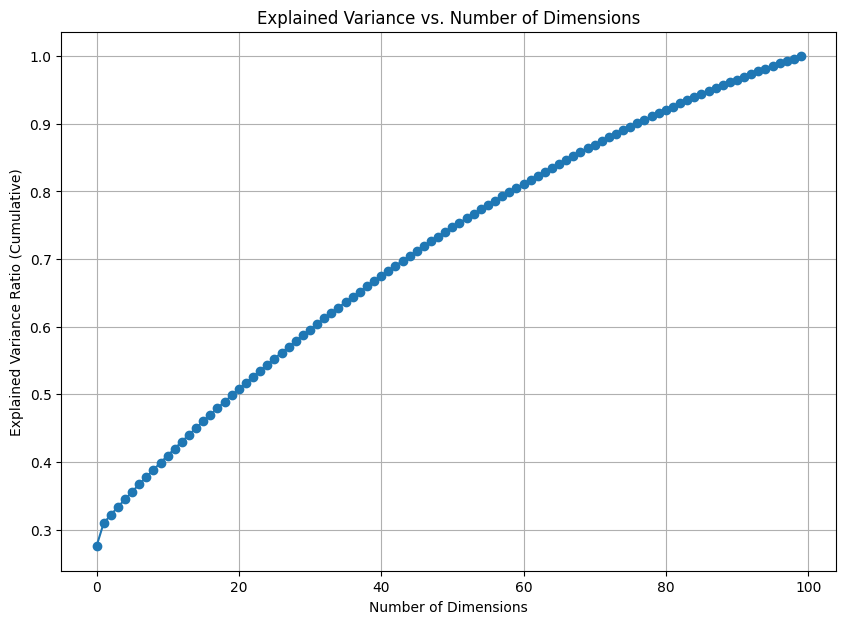

Number of dimensions to preserve 95% variance: 88
Reduced data shape (95% variance): (1000, 88)


In [5]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train is your training data (e.g., scaled MNIST data)
# For this example, let's create a dummy high-dimensional data
np.random.seed(42)
X_dummy_hd = np.random.randn(1000, 100) # 1000 instances, 100 features
# Introduce some correlation to simulate explainable variance
X_dummy_hd[:, 0] = X_dummy_hd[:, 0] * 5
X_dummy_hd[:, 1] = X_dummy_hd[:, 1] * 3 + X_dummy_hd[:, 0] * 0.7

pca_full = PCA()
pca_full.fit(X_dummy_hd)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Plot explained variance as a function of dimensions
plt.figure(figsize=(10, 7))
plt.plot(cumsum, marker='o', linestyle='-')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio (Cumulative)')
plt.title('Explained Variance vs. Number of Dimensions')
plt.grid(True)
plt.show()

# Find number of dimensions to preserve 95% variance
d_95_variance = np.argmax(cumsum >= 0.95) + 1
print(f"Number of dimensions to preserve 95% variance: {d_95_variance}")

# Alternatively, set n_components as a float between 0.0 and 1.0
pca_95 = PCA(n_components=0.95)
X_reduced_95 = pca_95.fit_transform(X_dummy_hd)
print(f"Reduced data shape (95% variance): {X_reduced_95.shape}")

### 8.3.7 PCA for Compression

Setelah reduksi dimensi, dataset akan memakan lebih sedikit ruang. Ini dapat mempercepat algoritma klasifikasi (misalnya, pengklasifikasi SVM) secara signifikan.

Dimungkinkan juga untuk mengembalikan dataset tereduksi ke dimensi aslinya ($784$ dimensi untuk MNIST) dengan menerapkan transformasi invers dari proyeksi PCA. Ini tidak akan mengembalikan data asli secara sempurna karena proyeksi kehilangan sedikit informasi (dalam variansi $5%$ yang dihilangkan), tetapi hasilnya akan mirip. Jarak kuadrat rata-rata antara data asli dan data yang direkonstruksi disebut **kesalahan rekonstruksi (reconstruction error)**.

Persamaan transformasi invers adalah $X_{recovered} = X_{d-proj} W_d^\intercal$.

Original MNIST-like data shape: (10, 784)
Reduced MNIST-like data shape: (10, 9)
Recovered MNIST-like data shape: (10, 784)
Reconstruction Error (conceptual): 5.012716373642845e-31


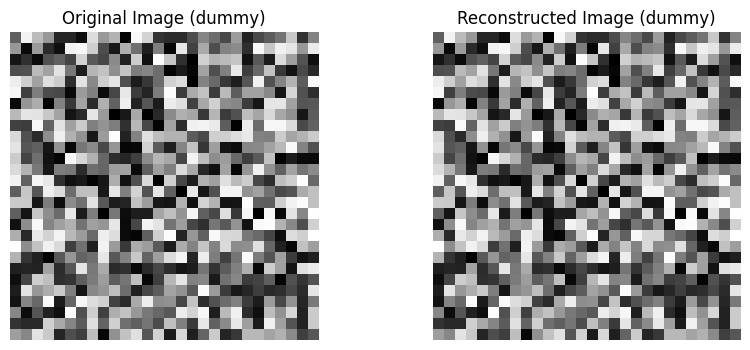

In [6]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Example with MNIST-like data (dummy)
# Simulate MNIST image: 28x28 = 784 features
np.random.seed(42)
X_mnist_dummy = np.random.rand(10, 784) # 10 dummy images

# Reduce dimensionality (e.g., to 154 dimensions for 95% variance)
pca_mnist = PCA(n_components=0.95) # Target explained variance
X_reduced_mnist = pca_mnist.fit_transform(X_mnist_dummy)
print(f"Original MNIST-like data shape: {X_mnist_dummy.shape}")
print(f"Reduced MNIST-like data shape: {X_reduced_mnist.shape}")

# Reconstruct the data
X_recovered_mnist = pca_mnist.inverse_transform(X_reduced_mnist)
print(f"Recovered MNIST-like data shape: {X_recovered_mnist.shape}")

# Calculate reconstruction error (conceptual)
reconstruction_error = np.mean((X_mnist_dummy - X_recovered_mnist)**2)
print(f"Reconstruction Error (conceptual): {reconstruction_error}")

# Visualize original vs. reconstructed (conceptual, flat image)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_mnist_dummy[0].reshape(28, 28), cmap='gray')
plt.title('Original Image (dummy)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_recovered_mnist[0].reshape(28, 28), cmap='gray')
plt.title('Reconstructed Image (dummy)')
plt.axis('off')
plt.show()

### 8.3.8 Randomized PCA

Jika Anda mengatur hyperparameter `svd_solver` ke `"randomized"`, Scikit-Learn menggunakan algoritma stokastik yang disebut **Randomized PCA**. Ini dengan cepat menemukan perkiraan $d$ komponen utama pertama. Kompleksitas komputasinya adalah $O(m \times d^2) + O(d^3)$, yang jauh lebih cepat daripada pendekatan SVD penuh $O(m \times n^2) + O(n^3)$ ketika $d$ jauh lebih kecil daripada $n$.

Secara default, `svd_solver` diatur ke `"auto"`: Scikit-Learn secara otomatis menggunakan algoritma randomized PCA jika $m$ atau $n$ lebih besar dari 500 dan $d$ kurang dari 80% dari $m$ atau $n$. Jika tidak, ia menggunakan pendekatan SVD penuh.

### 8.3.9 Incremental PCA

**Incremental PCA (IPCA)** dikembangkan untuk mengatasi masalah di mana seluruh dataset pelatihan tidak muat di memori. IPCA memungkinkan Anda untuk membagi dataset pelatihan menjadi mini-batch dan memasukkan satu mini-batch ke algoritma IPCA pada satu waktu. Ini berguna untuk dataset besar dan untuk menerapkan PCA secara online (yaitu, secara on the fly, saat instance baru tiba).

In [7]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

# Simulate a very large dataset that cannot fit in memory
m, n = 100000, 100  # 100,000 instances, 100 features
X_large = np.random.randn(m, n) # In reality, load parts from disk

n_batches = 100
inc_pca = IncrementalPCA(n_components=50) # Target 50 dimensions

# Simulate feeding mini-batches
for X_batch in np.array_split(X_large, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc_pca = inc_pca.transform(X_large)
print(f"Shape of X_large: {X_large.shape}")
print(f"Shape of X_reduced_inc_pca: {X_reduced_inc_pca.shape}")

Shape of X_large: (100000, 100)
Shape of X_reduced_inc_pca: (100000, 50)


### 8.3.10 Kernel PCA

**Kernel PCA (kPCA)** memungkinkan Anda untuk melakukan proyeksi nonlinier yang kompleks untuk reduksi dimensi dengan menerapkan "trik kernel" (kernel trick). Ini seringkali bagus dalam mempertahankan klaster instance setelah proyeksi, atau terkadang bahkan membuka dataset yang terletak dekat dengan manifold yang melengkung.

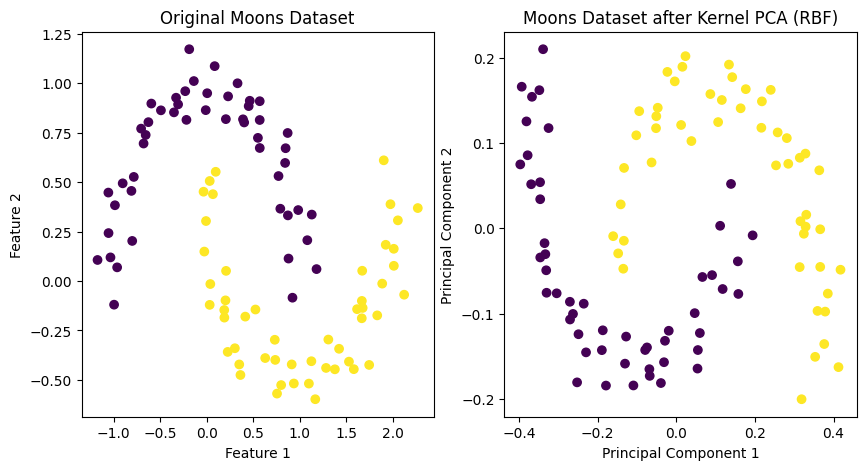

In [8]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate a non-linear dataset (moons dataset)
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

# Apply Kernel PCA with RBF kernel
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_kpca = rbf_pca.fit_transform(X_moons)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis')
plt.title("Original Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=y_moons, cmap='viridis')
plt.title("Moons Dataset after Kernel PCA (RBF)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

**Memilih Kernel dan Menyetel Hyperparameter**:
Karena kPCA adalah algoritma pembelajaran tanpa pengawasan (unsupervised learning), tidak ada ukuran kinerja yang jelas untuk membantu Anda memilih kernel dan nilai hyperparameter terbaik.

Namun, reduksi dimensi seringkali merupakan langkah persiapan untuk tugas pembelajaran terawasi (supervised learning) (misalnya, klasifikasi). Dalam kasus ini, Anda dapat menggunakan pencarian grid (grid search) untuk memilih kernel dan hyperparameter yang mengarah pada kinerja terbaik pada tugas akhir tersebut.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons
import numpy as np

X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=1)
grid_search.fit(X_moons, y_moons)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'kpca__gamma': np.float64(0.05), 'kpca__kernel': 'rbf'}
Best cross-validation score: 0.8295


Pendekatan lain, yang sepenuhnya tidak terawasi, adalah memilih kernel dan hyperparameter yang menghasilkan kesalahan rekonstruksi terendah. Namun, rekonstruksi tidak semudah pada PCA linier. Dalam kPCA, titik yang direkonstruksi akan berada di ruang fitur (feature space), yang mungkin berdimensi sangat tinggi atau bahkan tak terbatas. Untungnya, dimungkinkan untuk menemukan titik di ruang asli yang akan memetakan dekat dengan titik yang direkonstruksi. Titik ini disebut **pra-citra rekonstruksi (reconstruction pre-image)**. Anda kemudian dapat mengukur jarak kuadratnya ke instance asli dan memilih kernel serta hyperparameter yang meminimalkan kesalahan pra-citra rekonstruksi ini.

### 8.4 LLE (Locally Linear Embedding)

**Locally Linear Embedding (LLE)** adalah teknik reduksi dimensi nonlinier (NLDR) kuat lainnya. Ini adalah teknik Manifold Learning yang tidak bergantung pada proyeksi.
Cara kerjanya:
1.  Pertama, mengukur bagaimana setiap instance pelatihan secara linier berhubungan dengan tetangga terdekatnya (closest neighbors/c.n.).
2.  Kemudian, mencari representasi berdimensi rendah dari dataset di mana hubungan lokal ini paling baik dipertahankan.

Pendekatan ini sangat baik dalam "membuka" manifold yang melengkung, terutama ketika tidak terlalu banyak noise.

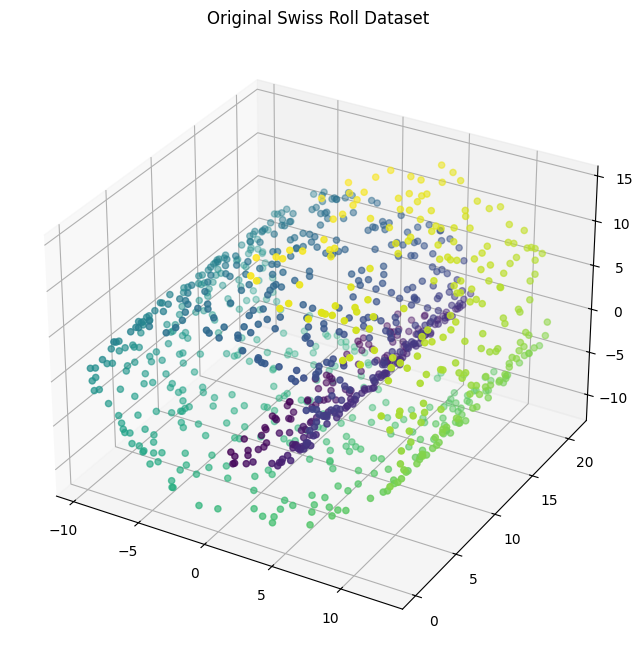

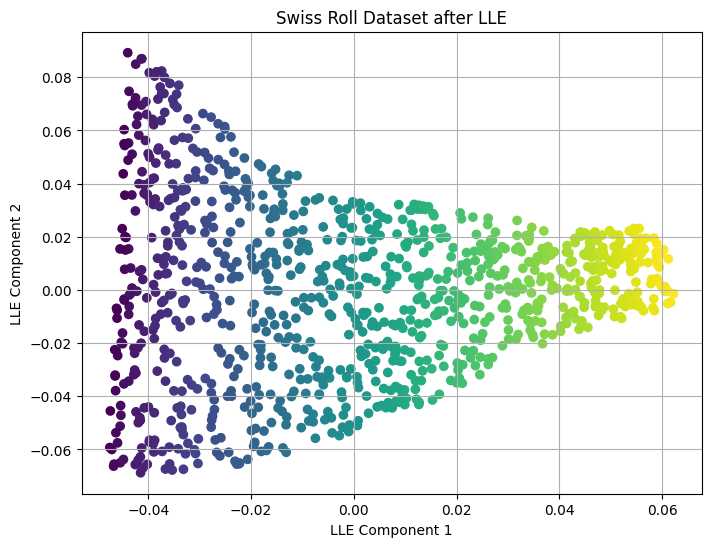

In [10]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset
X_swiss, t_swiss = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)

# Apply LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

# Visualize original Swiss Roll
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t_swiss, cmap='viridis')
ax.set_title("Original Swiss Roll Dataset")
plt.show()

# Visualize LLE reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t_swiss, cmap='viridis')
plt.title("Swiss Roll Dataset after LLE")
plt.xlabel("LLE Component 1")
plt.ylabel("LLE Component 2")
plt.grid(True)
plt.show()

Implementasi LLE di Scikit-Learn memiliki kompleksitas komputasi yang bervariasi, termasuk $O(m^2)$ untuk membangun representasi berdimensi rendah, yang membuatnya tidak cocok untuk dataset yang sangat besar.

## 8.5 Other Dimensionality Reduction Techniques

Scikit-Learn mengimplementasikan beberapa algoritma reduksi dimensi lainnya:
* **Random Projections**: Memproyeksikan data ke ruang berdimensi lebih rendah menggunakan proyeksi linier acak. Kualitas reduksi dimensi bergantung pada jumlah instance dan dimensi target, tetapi tidak pada dimensi awal.
* **Multidimensional Scaling (MDS)**: Mengurangi dimensi sambil mencoba mempertahankan jarak antara instance.
* **Isomap**: Membuat grafik dengan menghubungkan setiap instance ke tetangga terdekatnya, kemudian mengurangi dimensi sambil mencoba mempertahankan jarak geodesik antar instance.
* **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: Mengurangi dimensi sambil mencoba menjaga instance yang mirip tetap dekat dan instance yang tidak mirip tetap terpisah. Ini terutama digunakan untuk visualisasi, khususnya untuk memvisualisasikan klaster instance di ruang berdimensi tinggi (misalnya, untuk memvisualisasikan gambar MNIST dalam 2D).
* **Linear Discriminant Analysis (LDA)**: Algoritma klasifikasi yang, selama pelatihan, mempelajari sumbu paling diskriminatif antara kelas-kelas, dan sumbu ini kemudian dapat digunakan untuk menentukan hyperplane tempat data akan diproyeksikan. Manfaat pendekatan ini adalah proyeksi akan menjaga kelas-kelas terpisah sejauh mungkin, sehingga LDA merupakan teknik yang baik untuk mengurangi dimensi sebelum menjalankan algoritma klasifikasi lain.

---

**Catatan**: Untuk menjalankan kode-kode ini, pastikan Anda telah menginstal pustaka yang diperlukan (`numpy`, `matplotlib`, `scikit-learn`). Anda dapat menginstalnya menggunakan pip:
`pip install numpy matplotlib scikit-learn`

Beberapa kode mungkin memerlukan dataset tertentu (seperti MNIST atau Swiss Roll). Anda bisa menggunakan fungsi `make_moons` dan `make_swiss_roll` dari `sklearn.datasets` untuk contoh non-linear, atau mengunduh dataset yang lebih besar seperti MNIST dari `sklearn.datasets.fetch_openml` atau TensorFlow Datasets.

Struktur di atas memberikan dasar yang kuat untuk Bab 8. Anda dapat menambahkan lebih banyak detail, visualisasi, dan eksperimen sesuai kebutuhan Anda.